# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The key question in this case is "what drives the price of a car?" based on the attributes of a used car. My job is to identify the key features based on provided data set and identify a model that can predict the price so that used-car dealers can align inventory for improved sales.

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

from sklearn import set_config

set_config(display="diagram")

In [132]:
import pandas as pd
train = pd.read_csv('data/vehicles.csv')

In [133]:
# review columns and values

train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

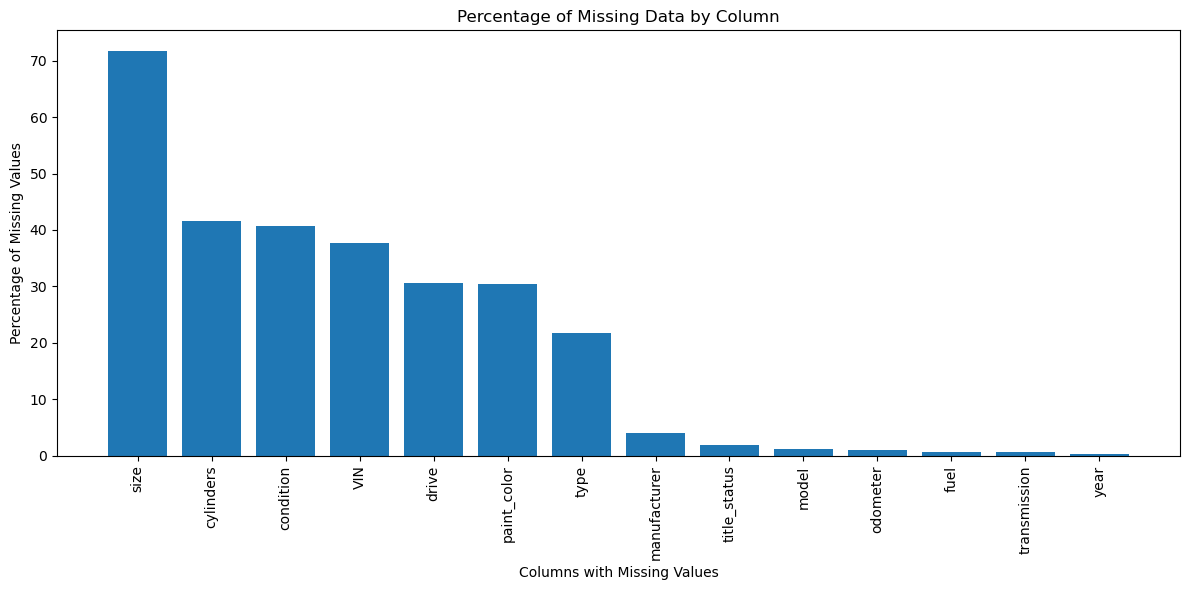

In [134]:
# Identified 'missing data' and plot it in bar chart

# percentage of missing values for each column
missing_data = train.isnull().sum() / len(train) * 100

# Filter columns with more than 0% missing values
missing_data = missing_data[missing_data > 0]

# Sort the columns by the percentage of missing data in descending order
missing_data = missing_data.sort_values(ascending=False)

# Create a bar plot of the missing data
plt.figure(figsize=(12, 6))
plt.bar(missing_data.index, missing_data.values)
plt.xticks(rotation=90)
plt.xlabel("Columns with Missing Values")
plt.ylabel("Percentage of Missing Values")
plt.title("Percentage of Missing Data by Column")
plt.tight_layout()
plt.savefig('images/{}.png'.format('Percentage of missing data by Column'), dpi=600)
plt.show()

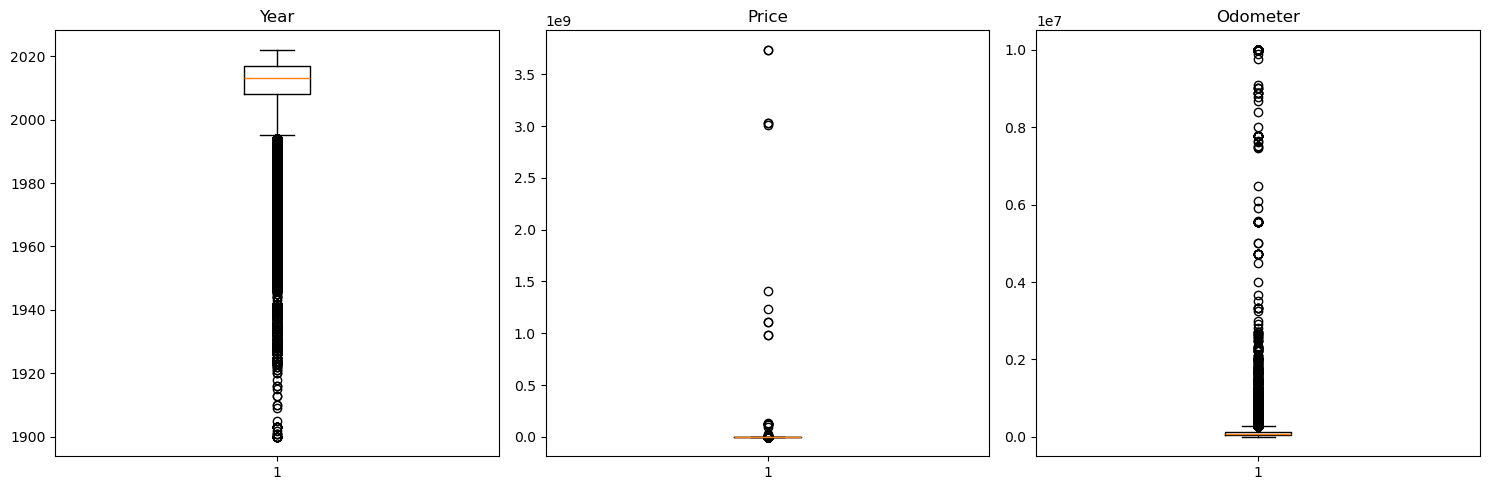

In [121]:
# Identify Outliers for Year, Price and Odometer

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.boxplot(train['year'].dropna())  # Drop NaN values before plotting
plt.title('Year')

plt.subplot(1, 3, 2)
plt.boxplot(train['price'].dropna())
plt.title('Price')

plt.subplot(1, 3, 3)
plt.boxplot(train['odometer'].dropna())
plt.title('Odometer')
plt.tight_layout()
plt.savefig('images/{}.png'.format('Year Price ODometer boxplot'), dpi=600)
plt.show()

In [122]:
# Check value counts for categorical variables
categorical_cols = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
for col in categorical_cols:
    print(f"Value counts for {col}:")
    print(train[col].value_counts())
    print("-" * 20)

Value counts for manufacturer:
manufacturer
ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427
infiniti            4802
lincoln             4220
volvo               3374
mitsubishi          3292
mini                2376
pontiac             2288
rover               2113
jaguar              1946
porsche             1384
mercury             1184
saturn              1090
alfa-romeo           897
tesla                868
fiat                 792
harley-davidson      153
ferrari               95
datsun

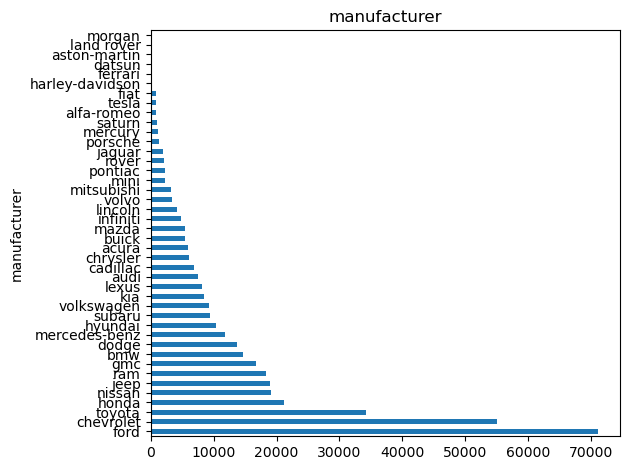

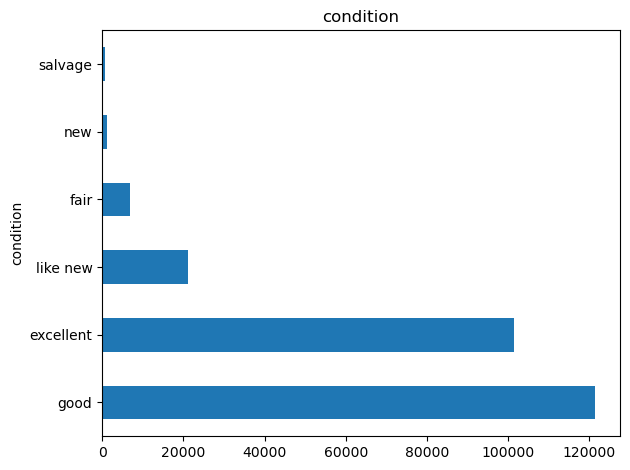

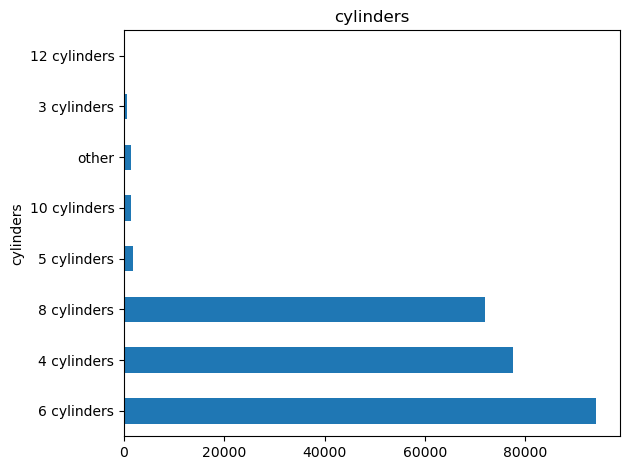

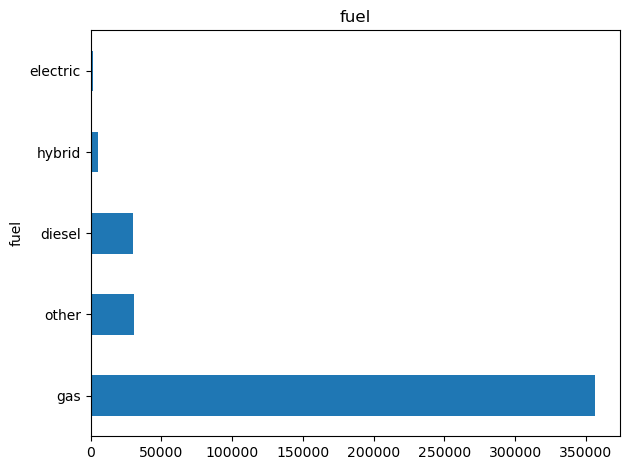

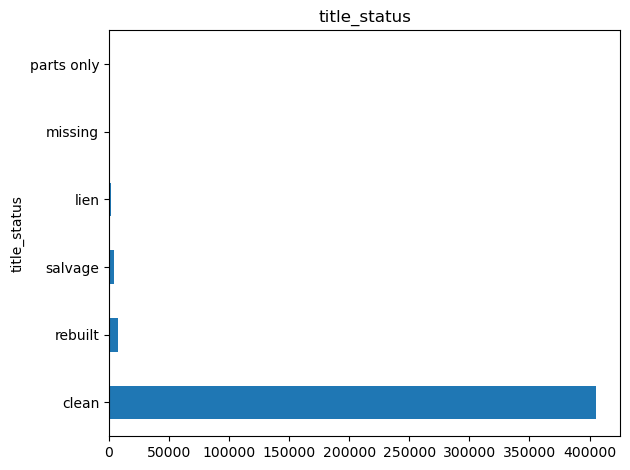

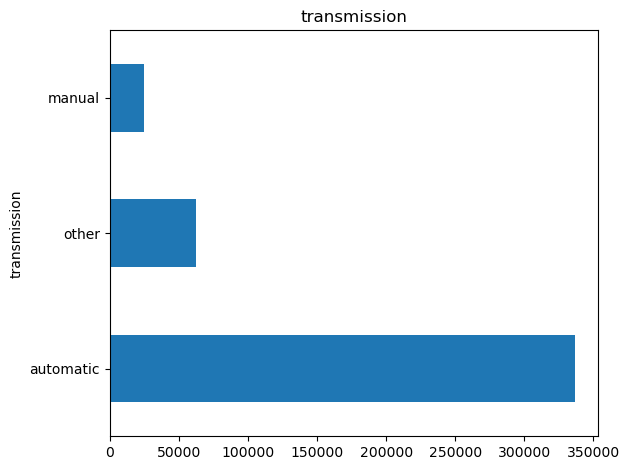

In [92]:
# Check value counts for categorical variables
categorical_cols = ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission']
for col in categorical_cols:
    train[col].value_counts().plot.barh()
    plt.title(col)
    plt.tight_layout()
    plt.savefig('images/{}.png'.format(col), dpi=600)
    plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [123]:
# drop columns with limited data or not applicable.
train = train.drop(['id', 'VIN', 'size'], axis=1)

# Drop rows with missing values in 'price'
train.dropna(subset=['price'], inplace=True)

# Remove outliers based on price 
train = train[train['price'] > 6000]
train = train[train['price'] < 100000]

# Handle missing values in odometer
train['odometer'] = train['odometer'].fillna(train['odometer'].median())

#Remove outliers based on odometer
train = train[train['odometer'] > 10000]
train = train[train['odometer'] < 160000]


#Remove outliers based on year
train = train[train['year'] > 2005]


train.describe()

,price,year,odometer
count,239870.000000,239870.000000,239870.000000
mean,23044.313853,2014.614254,72833.377092
std,13122.393811,3.390626,41111.864069
min,6044.000000,2006.000000,10005.000000
25%,12900.000000,2012.000000,35391.500000
50%,19995.000000,2015.000000,70640.000000
75%,30590.000000,2017.000000,105314.000000
max,99999.000000,2022.000000,159997.000000


In [124]:
#check updated data

train.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
27,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,NaN,pickup,white,al
28,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,NaN,pickup,blue,al
29,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,NaN,pickup,red,al
30,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,NaN,pickup,red,al
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [125]:
#Check numeric values with highest correlation to price
train_numeric = train.select_dtypes(include=['int64','float64'])
train_numeric.head()


highest_corr = train_numeric.corr()[['price']].nlargest(columns='price', n=2).index[1]

print(highest_corr)

year


In [126]:
train_numeric.head()

,price,year,odometer
27,33590,2014.0,57923.0
28,22590,2010.0,71229.0
29,39590,2020.0,19160.0
30,30990,2017.0,41124.0
31,15000,2013.0,128000.0


In [138]:
X = train_numeric.drop('price', axis = 1)
y = train_numeric['price']

#base line for liner regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

baseline_train = np.ones(shape = y_train.shape)*y_train.mean()
baseline_test = np.ones(shape = y_test.shape)*y_test.mean()
mse_baseline_train = mean_squared_error(baseline_train, y_train)
mse_baseline_test = mean_squared_error(baseline_test, y_test)

print(baseline_train.shape, baseline_test.shape)
print(f'Baseline for training data: {mse_baseline_train}')
print(f'Baseline for testing data: {mse_baseline_test}')


(167909,) (71961,)
Baseline for training data: 172462891.34789047
Baseline for testing data: 171558559.2002823


In [141]:
#linear regression model 

X1 = X_train[['year']]
lr = LinearRegression().fit(X1, y_train)
model_1_train_mse = mean_squared_error(y_train, lr.predict(X1))
model_1_test_mse = mean_squared_error(y_test, lr.predict(X_test[['year']]))

print(f'Train MSE: {model_1_train_mse: .2f}')
print(f'Test MSE: {model_1_test_mse: .2f}')


Train MSE:  128176349.69
Test MSE:  127397046.99


In [153]:
# Logarithmic Transformation of 'price' and 'odometer'
train['log_price'] = np.log1p(train['price'])
train['log_odometer'] = np.log1p(train['odometer'])

# One-hot encode categorical features
categorical_features = ['fuel', 'title_status', 'transmission'] 

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features), # Set sparse_output=False
    remainder='passthrough'
)

# Define features (X) and target (y)
X = train.drop(['price', 'log_price'], axis=1)
y = train['log_price'] # Use log-transformed price as the target variable


In [152]:
# Lasso Regression

model_selector_pipe = Pipeline([('poly_features', PolynomialFeatures(degree = 3, include_bias = False)),
                                ('scaler', StandardScaler()),
                                ('selector', SelectFromModel(Lasso())),
                                    ('linreg', LinearRegression())])

selector = SelectFromModel(Lasso())
selector.transform(X_train)

selector_train_mse = ''
selector_test_mse = ''


model_selector_pipe.fit(X_train, y_train)
selector_train_mse = mean_squared_error(y_train, model_selector_pipe.predict(X_train))
selector_test_mse = mean_squared_error(y_test, model_selector_pipe.predict(X_test))


C:\Users\shona_3kwuxkj\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


ValueError: when `importance_getter=='auto'`, the underlying estimator Lasso should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

##
based on extensive analysis of used car data, we have found that the most important feature predicting price is "Year"

Through model evaluation, the linear regression model with features including 'year' showed good model performance.

As a result I would highly recommend going forward that you adjust your car inventory with a strong emphasis ensuring that The 'year' is the latest as possible. 



### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.